In [3]:
import numpy as np
import tensorflow as tf
import os
import rasterio
'''
import keras
from keras.layers import BatchNormalization, TimeDistributed
'''

import tensorflow.keras as keras
from tensorflow.python.keras.layers import BatchNormalization, TimeDistributed
from tensorflow.python.keras.utils import Sequence
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras import optimizers

from modis_utils.generators import OneOutputGenerator
from modis_utils.misc import get_data_test, get_target_test, cache_data, restore_data
from modis_utils.model.core import compile_model, conv_lstm_2D, conv_2D
from modis_utils.model.loss_function import mse_with_mask, mse_with_mask_batch
from modis_utils.model.eval import predict_and_visualize_by_data_file_one_output
from matplotlib import pyplot as plt


Using TensorFlow backend.


In [4]:
def PSNRLoss(y_true, y_pred):
    return -10. * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.)

In [78]:
input_timesteps = 12
img_height = 128
img_width = 128

adam = optimizers.Adam(lr=0.00005)

sgd = optimizers.SGD(lr=0.0001)

input_shape = (input_timesteps, img_height, img_width, 1)
compile_params = {'optimizer': sgd, 'loss': 'mse', 'metrics': [PSNRLoss]}

# Model architecture
source = keras.Input(name='seed', shape=input_shape, dtype=tf.float32)
model = conv_lstm_2D(filters=64, kernel_size=3, strides=1,padding='same')(source)
model = BatchNormalization()(model)
model = conv_lstm_2D(filters=64, kernel_size=3, strides=1,padding='same')(model)
model = BatchNormalization()(model)
model = conv_lstm_2D(filters=64, kernel_size=3, strides=1,padding='same')(model)
model = BatchNormalization()(model)
model = conv_lstm_2D(filters=64, kernel_size=3, strides=1,padding='same')(model)
model = BatchNormalization()(model)
model = conv_lstm_2D(filters=64, kernel_size=3, strides=1,padding='same', return_sequences=False)(model)
model = BatchNormalization()(model)

predict_img = conv_2D(filters=1, kernel_size=3, strides=1,padding='same')(model)
model = keras.Model(inputs=[source], outputs=[predict_img])

# Compile model
model = compile_model(model, compile_params)
# model.summary()

In [3]:
totalPredicted = []
listFile = os.listdir('output/')
nTrain = int(len(listFile) * 0.6)
nVal = int(len(listFile) * 0.25)
testFiles = listFile[nTrain+nVal:]
data = restore_data('output/{0}'.format(testFiles[50]))
listModels = ['weights.h5', 'weights_2.h5', 'weights_3.h5', 'sgd_weights_3.h5', 'sgd_weights_2.h5', 'sgd_weights_1.h5', 'sgd_weights_final.h5']
for modelName in listModels:    
    model.load_weights(modelName)
    predicted = model.predict(np.expand_dims(np.expand_dims(data[:-1,:,:], axis=0), axis=-1))
    totalPredicted.append(predicted[0,:,:,0])

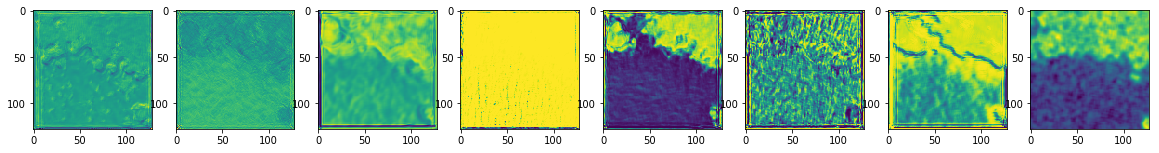

In [5]:
totalPredicted.append(data[-1])
fig = plt.figure(figsize=(20, 20))
for i in range(1, 9):
    fig.add_subplot(1, 8, i)
    plt.imshow(totalPredicted[i - 1])

# Fully Testing

In [5]:
listDir = os.listdir('./GeoTiffData/')[-13:]
testData = [rasterio.open('./GeoTiffData/' + folder + '/data.tif').read(1)[650:3210,460:4300] for folder in listDir]


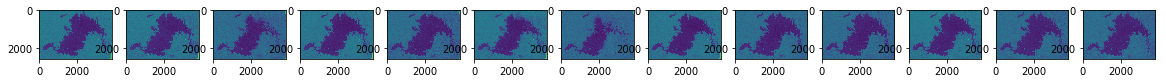

In [6]:
fig = plt.figure(figsize=(20, 20))
for i in range(1, 14):
    fig.add_subplot(1, 13, i)
    plt.imshow(testData[i - 1])

In [7]:
testData = np.asarray(testData)
xSize = 128
ySize = 128

nX = testData[0].shape[0] // 128
nY = testData[0].shape[1] // 128

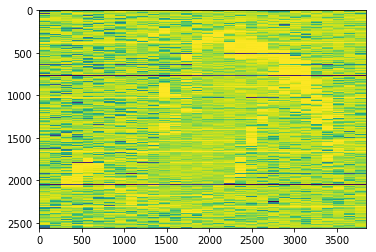

In [12]:
res = testData[0] # reference
model = load_model('model_sgd_00001.h5', custom_objects={"PSNRLoss": PSNRLoss})

for i in range(nX):
    for j in range(nY):        
        predicted = model.predict(np.expand_dims(np.expand_dims(testData[:-1,i * xSize:(i + 1)*xSize, j * ySize:(j + 1)*ySize], axis=0), axis=-1))
        res[i * xSize:(i + 1)*xSize, j * ySize:(j + 1)*ySize] = predicted[:,:,0]
plt.imshow(res)